In [6]:
# torch
import torch
from torch import nn
import torchvision
from torch import nn
from torch.utils import tensorboard
writer = tensorboard.SummaryWriter("logs")

# 其他
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import copy
import json
import os
import sys 
import time
from PIL import Image

In [7]:
# 数据
from torchvision.transforms import ToTensor, Resize, CenterCrop, Normalize, \
RandomCrop, RandomHorizontalFlip, RandomVerticalFlip, RandomGrayscale, RandomRotation, \
ColorJitter

# 存放位置
data_dir = "./dataset/flower_data/"
train_dir = "train"
test_dir = "valid"
batch_size = 32

# 数据分类为 - train, valid
dataset_class = ['train', 'valid']

# transform
data_transforms = {
    dataset_class[0]: torchvision.transforms.Compose([
        ToTensor(),
        Resize(254),
        RandomVerticalFlip(p=0.5),
        RandomVerticalFlip(p=0.5),
        RandomRotation(45),
        RandomCrop(224),
        RandomGrayscale(p=0.5),
        ColorJitter(brightness=0.2, contrast=0.1,saturation=0.1),
        Normalize([0.485, 0.456, 0.406],[0.229,0.224,0.255]),
    ]),
    dataset_class[1]: torchvision.transforms.Compose([
        ToTensor(),
        Resize(254),
        CenterCrop(224),
        Normalize([0.485, 0.456, 0.406],[0.229,0.224,0.255]),
    ]),
}

# 将transform后的图片还原成可以用matplotlib展示的格式
def img_convert(tensor_img):
    """输入单个的transform后的图片，转换回原来图片的格式"""
    img = tensor_img.clone().detach().numpy() # clone()：拷贝为新的地址，但是梯度和原有的关联，detach()和clone()相反
    img = img.squeeze() # squeeze 将多余的维度去掉，比如(1,3,2,1) -> (3,2) # 这一步可以省略
    img = img.transpose(1,2,0) # tensor格式的图片(3,h,w) -> (h,w,3)
    img = img * np.array((0.229, 0.224, 0.225)) + np.array((0.485, 0.456, 0.406)) # 将normalize的图片还原
    img = img.clip(0, 1)
    return img

# 加载数据
datasets = {x: torchvision.datasets.ImageFolder(os.path.join(data_dir, x), transform=data_transforms[x]) for x in dataset_class}
dataloaders = {x: torch.utils.data.DataLoader(datasets[x],batch_size=batch_size,shuffle=True) for x in dataset_class}

# 数据集分类是分成1,2,3,...class_name是json格式的数字对应的花名
with open(os.path.join(data_dir, "cat_to_name.json"), "r") as f:
    class_names = json.load(f)

In [8]:
# 展示 torchvision.datasets.ImageFolder
print(type(datasets['train']), dir(datasets['train'])[37:])
print(datasets['train'].loader)
print(datasets['train'].classes)
print(datasets['train'].targets[:10])
print(datasets['train'].imgs[:10])

<class 'torchvision.datasets.folder.ImageFolder'> ['class_to_idx', 'classes', 'extensions', 'extra_repr', 'imgs', 'loader', 'make_dataset', 'root', 'samples', 'target_transform', 'targets', 'transform', 'transforms']
<function default_loader at 0x000002007B2EC1F0>
['1', '10', '100', '101', '102', '11', '12', '13', '14', '15', '16', '17', '18', '19', '2', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '3', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '4', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '5', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '6', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '7', '70', '71', '72', '73', '74', '75', '76', '77', '78', '79', '8', '80', '81', '82', '83', '84', '85', '86', '87', '88', '89', '9', '90', '91', '92', '93', '94', '95', '96', '97', '98', '99']
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[('./dataset/flower_data/train\\1\\image_06734.jpg', 0), ('./dataset/flower_data/train\\1\\image_

In [9]:
# 展示torch.utils.data.DataLoader
train_loader = dataloaders['train']
# train_loader[0] # TypeError: 'DataLoader' object is not subscriptable
train_iter = iter(train_loader)
next(train_iter)[0][0].shape # 第一个0是选中imgs,第二个0是选择batch中的第一个Img

torch.Size([3, 224, 224])

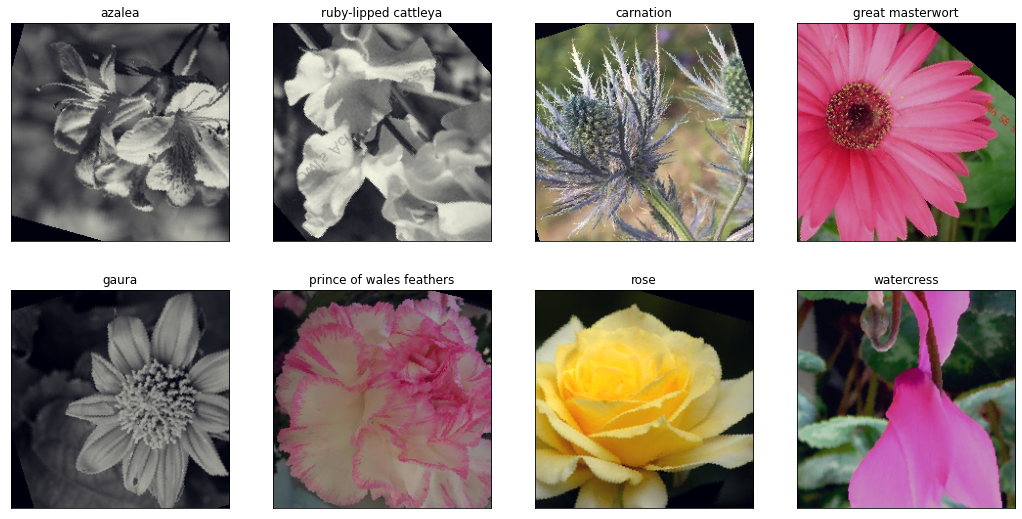

In [10]:
# 展示数据
fig = plt.figure(figsize=(18,9))
cows,rows = 4,2

train_loader = dataloaders['train']
train_loader_iter = iter(train_loader)
train_partdata = next(train_loader_iter) # train_partdata[inx] idx=0是imgs，idx=1是targets

for idx in range(cows*rows):
    ax = fig.add_subplot(rows, cows, idx+1, xticks=[], yticks=[])
    ax.set_title(class_names[str(train_partdata[1][idx].item())])
    plt.imshow(img_convert(train_partdata[0][idx]))
plt.show()

In [11]:
# 模型类
class LoadModel(object):
    def __init__(self, model_name='resnet152', n_class=102, is_pretrained=True, is_feat_extr=True, train_only_fc=True, device='cpu'):
        model_name = eval('torchvision.models.'+model_name)
        # 加载模型
        self.model = model_name(pretrained=is_pretrained)
        # 是否特征提取 - 提取特征要放在更改全连接层前面
        LoadModel.set_parameter_requires_grad(self.model, is_feat_extr)
        # 修改全连接层
        self.model.fc = nn.Sequential(
            nn.Linear(self.model.fc.in_features, n_class),
            nn.LogSoftmax(dim=1), # 不能用直接用Softmax,否则在loss.backward()那有bug报错
            )
        # 修改完模型后设置device
        # 要先model.to(device)之后才能把参数传入optim.xxx(params_to_update=..., lr=...)
        self.model = self.model.to(device)
        
        # 需要更新的参数，列表的形式，优化器的第一个参数
        self.params_to_update = []
        self.name_to_updata = []
        # 是否只训练全连接层
        if train_only_fc and is_feat_extr:
            for name,param in self.model.named_parameters():
                if param.requires_grad == True:
                    self.params_to_update.append(param)
                    self.name_to_updata.append(name)
        else:
            self.params_to_update = self.model.parameters()
            self.name_to_updata.append('full')

    
    @staticmethod
    def set_parameter_requires_grad(model, feature_extracting):
        if feature_extracting:
            for param in model.parameters():
                param.requires_grad = False
    
    def ret(self):
        return self.model, self.params_to_update

In [12]:
# device
device = torch.device("dml")

# 模型
loadmodel = LoadModel(device=device)
model, params_to_update = loadmodel.ret()

# 优化器设置
optimizer = torch.optim.Adam(params_to_update, lr=1e-2)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)#学习率每7个epoch衰减成原来的1/10

# costfunction
#最后一层已经LogSoftmax()了，所以不能nn.CrossEntropyLoss()来计算了，nn.CrossEntropyLoss()相当于logSoftmax()和nn.NLLLoss()整合
cost = torch.nn.NLLLoss()
cost = cost.to(device)

# epoch
n_epoch = 50

In [13]:
# 训练函数
def train_model(model, dataloaders, optimizer, cost_fc, n_epochs, save_name, device='cpu'):
    # 开始时间
    since = time.time()

    # device
    # model = model.to(device)
    # cost_fc = cost_fc.to(device)
    
    # 精确度和损失的记录
    train_losses = []
    valid_losses = []
    train_acc_hist = []
    valid_acc_hist = []

    # 学习率变化
    lrs = [optimizer.param_groups[0]['lr']]
    
    # 最好的精度所对应的参数
    best_acc = 0
    best_model_wts = copy.deepcopy(model.state_dict())
    
    # 训练开始
    for epoch in range(n_epochs):
        print('Epoch {}/{}'.format(epoch, n_epochs - 1))
        print('-' * 10)
        
        for phase in ['train','valid']:
            if phase == 'train':
                model.train()
            elif phase == 'valid':
                model.eval()

            # 每个epoch开始前初始化损失和正确率 
            running_loss = 0.0
            running_corrects = 0

            # 读取数据
            for imgs, targets in dataloaders[phase]:

                imgs = imgs.to(device)
                targets = targets.to(device)

                # 梯度清零
                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == "train"):
                    out = model(imgs)
                    loss = cost_fc(out, targets)

                    if phase == "train":
                        # print([x.grad for x in optimizer.param_groups[0]['params']])
                        loss.backward()
                        # print([x.grad for x in optimizer.param_groups[0]['params']])
                        optimizer.step()

                probs, pres = torch.max(out, 1)
                running_loss += loss.item() * imgs.size()[0]
                running_corrects += (torch.sum(pres.to('cpu') == targets.to('cpu')))
                
            
            # 一个epoch的train or valid结束
            epoch_loss = running_loss / len(dataloaders[phase].dataset)  # len(dataloader[phase]) == 205, len(dataloader[phase].dataset) == 6552
            epoch_acc = running_corrects / len(dataloaders[phase].dataset)

            # 打印时间和损失
            time_elapsed = time.time() - since
            print('Time elapsed {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
            
            # 保存最好的模型
            if phase == 'valid' and epoch_acc > best_acc:
                best_acc = epoch_acc
                model_temp = copy.deepcopy(model).to('cpu') # 要to('cpu'),否则报错
                best_model_wts = model_temp.state_dict() # 可以直接保存模型
                torch.save(best_model_wts, save_name)

            if phase == 'train':
                train_losses.append(epoch_loss)
                train_acc_hist.append(epoch_acc)
            elif phase == 'valid':
                valid_losses.append(epoch_loss)
                valid_acc_hist.append(epoch_acc)
                scheduler.step()

        # 优化器学习率
        print('Optimizer learning rate : {:.7f}'.format(optimizer.param_groups[0]['lr']))
        lrs.append(optimizer.param_groups[0]['lr'])
        print()

    # 所有 epoch结束
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))
    
    # 训练完后用最好的一次当做模型最终的结果
    model.load_state_dict(best_model_wts)
    return model, valid_acc_hist, train_acc_hist, valid_losses, train_losses, lrs 


In [14]:
# 训练开始
model, valid_acc_hist, train_acc_hist, valid_losses, train_losses, lrs = train_model(model, dataloaders, optimizer, cost, n_epoch, save_name='checkpoint.pth', device=device)

Epoch 0/49
----------
Time elapsed 2m 33s
train Loss: 5.4216 Acc: 0.4185


KeyboardInterrupt: 